# CCAI Challenge Project - Roggio (1000037341), Vinciguerra (1000042241)

In questo progetto andremo ad analizzare il dataset CCAIUNICT-2023, al fine di creare un modello per la classificazione di oggetti.

Controllo relativo alla disponibilità dell'acceleratore GPU.

In [45]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Creazione della classe che consentirà di importare il dataset, ImageFolderNames() (sovrascrive ImageFolder, rendendo disponibile anche il nome dell'immagine) e la classe FileCrop() per eseguire il crop delle immagini secondo i riquadri specificati in "train.csv" e "test.csv".

In [46]:
import random
from torchvision.datasets import ImageFolder

class ImageFolderNames(ImageFolder):
    def __init__(self, root, split, transform=None, target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.testSample=[]
        self.trainSample=[]
        
        for name in self.samples:
            if name[0].split('/')[-2]=="test":
                self.testSample.append(name)
            else:
                self.trainSample.append(name)
        
        if split=="test":
            self.samples=self.testSample
        else:
            self.samples=self.trainSample
            
        random.shuffle(self.samples)       
            
        self.transform=transform
        
    def __getitem__(self, index):
        path, target = self.samples[index]
        image = self.loader(path)
        if self.transform:
            image=self.transform((image, target, path.split('/')[-1]))
        return image, target, path.split('/')[-1]

In [47]:
class FileCrop():
        def __init__(self, root, mode):
            self.elementsCrop=None
            for  dirname, _, filenames in os.walk(root):
                for filename in filenames:
                    if(filename == mode+'.csv'):
                        data = pd.read_csv(dirname+filename)
                        for i in range(len(data)):
                            data.loc[i, 'image']=data.loc[i, 'image'].split('/')[-1]
                        self.elementsCrop= data.set_index("image")
        def __call__(self, image):
            name=image[2]
            cropped_image = image[0].crop((self.elementsCrop['x1'][name], self.elementsCrop['y1'][name], self.elementsCrop['x2'][name], self.elementsCrop['y2'][name]))
            return cropped_image

Importazione del dataset, trasformazione delle features, divisione del train dataset dal validation, generazione del validation set e dei loader.

In [48]:
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

batch_size = 32

root='/kaggle/input/ccaiunict-2023/'

train_transform = T.Compose([
    FileCrop(root,"train"),
    T.Resize(150),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor()
])

test_transform = T.Compose([
    FileCrop(root,"test"),
    T.Resize(150),
    T.ToTensor()
])

# Instantiate datasets
train = ImageFolderNames(root+"train", split="train", transform=train_transform)
test = ImageFolderNames(root, split="test", transform=test_transform)

# Validation set
num_train = len(train)
train_idx=list(range(num_train))

num_val = round(num_train* 0.1)
num_train = num_train - num_val
val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]

val = Subset(train, val_idx)
train = Subset(train, train_idx)

train_loader = DataLoader(train, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, num_workers=2, shuffle=False)
loaders = {"train": train_loader, "val": val_loader, "test": test_loader}

Visualizzazione di un'immagine dal dataset.

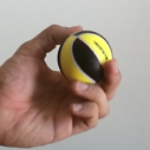

In [49]:
prova=train[500][0]
#prova=val[100][0]
#prova=test[100][0]

Image.fromarray((prova*255).numpy().transpose(1,2,0).astype('uint8'))

Definizione della CNN, utilizzo di alcuni layer di VGG19 e integrazione di tali layer in un'architettura creata da zero.

In [50]:
import torchvision.models as models 
import torchvision.models.vgg as vgg
import torch.nn as nn 

class Model(nn.Module):
    def __init__(self):
        super().__init__();
        model=vgg.vgg16_bn(weights=None)
        layers = list(model.features.children())[:8]

        # Integrazione dei layer prelevati da VGG
        self.vgg = nn.Sequential(*layers)
        
        # Creazione dei layer convoluzionali
        self.conv_layers = nn.Sequential(
            # Layer 1
            nn.Conv2d(128, 128, kernel_size=3, padding=0, stride = 3), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 2
            nn.Conv2d(128, 256, kernel_size=3, padding=0, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 3
            nn.Conv2d(256, 512, kernel_size=2, padding=0, stride = 1),
            nn.ReLU(),
            # Layer 4
            nn.Conv2d(512, 1024, kernel_size=2, padding=0, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),        
        )
        
        # Crazione dei layer fully-connected
        self.fc_layers = nn.Sequential(
            # Layer FC
            nn.Linear(1*1024*2*2, 1024), 
            nn.ReLU(),
            # Layer di classificazione
            nn.Linear(1024, 8) #8 classi
            
        )

    def forward(self, x):
        x = self.vgg(x)
        x = self.conv_layers(x) 
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x) 
        return x
    
# Test del modello
model=Model()
model.eval()
test_input = train[0][0].unsqueeze(0)
print(test_input.size())
print("Model output size:", model(test_input).size())

model.to(device)

torch.Size([1, 3, 150, 150])
Model output size: torch.Size([1, 8])


Model(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv_layers): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1))
    (7): ReLU

Stampa disposizione dati nel loader di train.

In [51]:
for batch in loaders["train"]:
    immagine = batch[0]          #immagini
    classeCorretta = batch[1]    #classi
    nomeImmagine = batch[2]      #nome immagine
   # print(immagine, classeCorretta, nomeImmagine)

Allenamento della rete.

In [52]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00001)

best_val_accuracy = 0
test_accuracy_at_best_val = 0

try:
    # Inizializzazione delle variabili relative alla storia di loss e accuracy
    history_loss = {"train": [], "val": []}
    history_accuracy = {"train": [], "val": []}
    # Processamento delle epoche
    for epoch in range(10):
        # Inizializzazione delle variabili per ogni epoca
        sum_loss = {"train": 0, "val": 0}
        sum_accuracy = {"train": 0, "val": 0}
        # Processamento di ogni split
        for split in ["train", "val"]:
            if split == 'train':
                model.train()
            else:
                model.eval()
            # Processamento di ogni batch
            for batch in loaders[split]:
                # Esegui su GPU
                input = batch[0].to(device)
                labels = batch[1].to(device)
                # Reset del gradiente
                optimizer.zero_grad()
                # Creazione output
                pred = model(input)
                loss = criterion(pred, labels)
                # Aggiornamento della loss
                sum_loss[split] += loss.item()
                if split == "train":
                    # Calcola il gradiente
                    loss.backward()
                    # Ottimizza
                    optimizer.step()
                # Calcola l'accuracy
                _,pred_labels = pred.max(1)
                batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                # Aggiornamento dell'accuracy
                sum_accuracy[split] += batch_accuracy
        # Calcola l'accuracy loss/accuracy per ogni epoca
        epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val"]}
        epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val"]}
        # Print delle informazioni
        print(f"Epoch {epoch+1}:",
              f"TrL={epoch_loss['train']:.4f},",
              f"TrA={epoch_accuracy['train']:.4f},",
              f"VL={epoch_loss['val']:.4f},",
              f"VA={epoch_accuracy['val']:.4f}")
        for split in ["train", "val"]:
            history_loss[split].append(epoch_loss[split])
            history_accuracy[split].append(epoch_accuracy[split])
except KeyboardInterrupt:
    print("Interrupted")

Epoch 1: TrL=2.0616, TrA=0.1972, VL=2.0592, VA=0.4500
Epoch 2: TrL=1.9105, TrA=0.3833, VL=1.7039, VA=0.4313
Epoch 3: TrL=1.3812, TrA=0.5479, VL=1.1099, VA=0.6375
Epoch 4: TrL=0.9633, TrA=0.6819, VL=0.8776, VA=0.7250
Epoch 5: TrL=0.7758, TrA=0.7417, VL=0.7327, VA=0.7625
Epoch 6: TrL=0.6453, TrA=0.7903, VL=0.5936, VA=0.8438
Epoch 7: TrL=0.5506, TrA=0.8313, VL=0.4985, VA=0.8688
Epoch 8: TrL=0.4776, TrA=0.8424, VL=0.4818, VA=0.8625
Epoch 9: TrL=0.4136, TrA=0.8708, VL=0.4331, VA=0.8750
Epoch 10: TrL=0.3850, TrA=0.8757, VL=0.3908, VA=0.8938


Visualizzazione informazioni sull'andamento della loss e dell'accuracy durante il training.

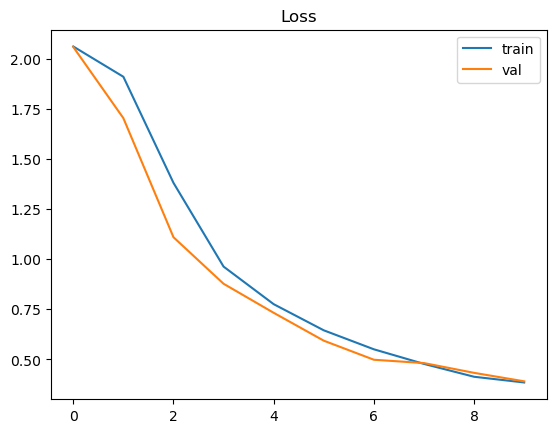

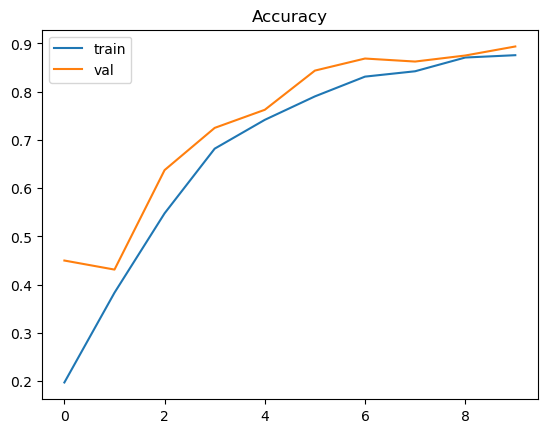

In [53]:
# Plot della loss
plt.title("Loss")
for split in ["train", "val"]:
    plt.plot(history_loss[split], label=split)
plt.legend()
plt.show()

# Plot della accuracy
plt.title("Accuracy")
for split in ["train", "val"]:
    plt.plot(history_accuracy[split], label=split)
plt.legend()
plt.show()

Classificazione delle 800 immagini presenti nel test set e memorizzazione dell'output nel file "submission.csv".

In [54]:
import random
import os

# Eliminazzione "submission.csv", se presente.
if os.path.exists("submission.csv"):
    os.remove("submission.csv")
    
for i in range(800):
    input = test[i][0]
    name_input=test[i][2]
    # Predizione della classe
    model.eval()
    with torch.no_grad():
        output = model(input.unsqueeze(0).to(device))
    _,pred = output.max(1)
    pred = pred.item()
    
    #scrittura su file submission.csv: name_input, pred
    tmp = pd.DataFrame({
        "image": [name_input],
        "class": [pred]
    })

    file_name="submission.csv"

    if os.path.exists("submission.csv"):
        record=pd.read_csv("submission.csv",sep=",",decimal=".")
        record=pd.concat([record, tmp], ignore_index = True, sort = False)
        record.to_csv("submission.csv" ,index=False, header=True, encoding='utf-8-sig')
    else:
        tmp.to_csv("submission.csv" ,index=False, header=True, encoding='utf-8-sig')
        
print("File salvato con successo.")

File salvato con successo.


Visualizzazione del contenuto di "submission.csv".

In [55]:
print(pd.read_csv("submission.csv",sep=",",decimal=".").to_string())

       image  class
0    058.jpg      0
1    336.jpg      0
2    200.jpg      0
3    509.jpg      0
4    377.jpg      1
5    418.jpg      5
6    476.jpg      3
7    212.jpg      7
8    508.jpg      5
9    501.jpg      4
10   676.jpg      5
11   716.jpg      1
12   189.jpg      3
13   333.jpg      7
14   017.jpg      4
15   181.jpg      7
16   236.jpg      2
17   541.jpg      1
18   562.jpg      1
19   313.jpg      0
20   557.jpg      7
21   191.jpg      2
22   324.jpg      4
23   223.jpg      2
24   163.jpg      2
25   130.jpg      0
26   309.jpg      0
27   392.jpg      2
28   419.jpg      1
29   082.jpg      7
30   071.jpg      2
31   365.jpg      0
32   512.jpg      0
33   741.jpg      4
34   393.jpg      0
35   095.jpg      0
36   519.jpg      0
37   497.jpg      5
38   427.jpg      3
39   785.jpg      0
40   609.jpg      7
41   659.jpg      4
42   023.jpg      1
43   696.jpg      3
44   056.jpg      0
45   274.jpg      3
46   695.jpg      4
47   542.jpg      3
48   380.jpg      7
